## Guided Project: Analyzing NYC High School Data
we explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the **SAT, or Scholastic Aptitude Test**, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of **800 points**. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

 - [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) SAT scores for each high school in New York City for 2012.
 - [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) Attendance information for each school in New York City for 2010-2011.
 - [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) Information on class size for each school for 2010-2011.
 - [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject) for 2010-2011.
 - [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) The percentage of students who graduated, and other outcome information for 2005-2010.
 - [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) Demographic information for each school
 - [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) Surveys of parents, teachers, and students at each school
 
 
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.



In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
%matplotlib inline

In [2]:
data_files = [
    "ap_results.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "school_attendance.csv",
    "sat_scores.csv",
    "hs_directory.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d


## Open survey datasets

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN column

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_scores"][c] = pd.to_numeric(data["sat_scores"][c], errors="coerce")

data['sat_scores']['sat_score'] = data['sat_scores'][cols[0]] + data['sat_scores'][cols[1]] + data['sat_scores'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_results"][col] = pd.to_numeric(data["ap_results"][col], errors="coerce")

## Combine datasets

In [8]:
combined = data["sat_scores"]

combined = combined.merge(data["ap_results"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add school district number

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.sort_values(ascending=False).head(11))

sat_score                          1.000000
SAT Writing Avg. Score             0.987771
SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
Advanced Regents - % of cohort     0.771566
Advanced Regents - % of grads      0.739927
Total Regents - % of cohort        0.667603
white_per                          0.620718
Total Grads - % of cohort          0.584234
asian_per                          0.570730
AP Test Takers                     0.523140
Name: sat_score, dtype: float64


In [11]:
combined.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Data columns (total 160 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    DBN                                   363 non-null    object 
 1    SCHOOL NAME                           363 non-null    object 
 2    Num of SAT Test Takers                363 non-null    object 
 3    SAT Critical Reading Avg. Score       363 non-null    float64
 4    SAT Math Avg. Score                   363 non-null    float64
 5    SAT Writing Avg. Score                363 non-null    float64
 6    sat_score                             363 non-null    float64
 7    SchoolName                            363 non-null    object 
 8    AP Test Takers                        363 non-null    float64
 9    Total Exams Taken                     363 non-null    float64
 10   Number of Exams with scores 3 4 or 5  363 non-null    float64
 11   Demo

<ipython-input-11-18daee2bbe43>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  combined.info(verbose=True, null_counts=True)


In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

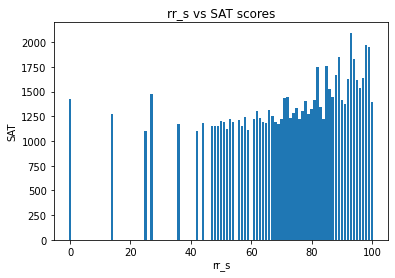

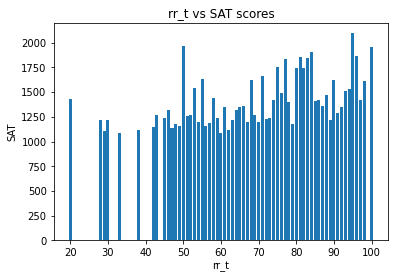

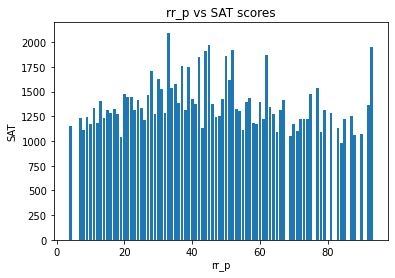

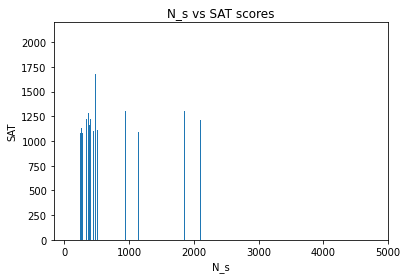

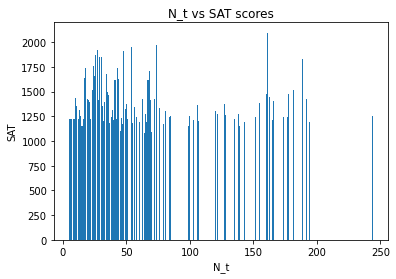

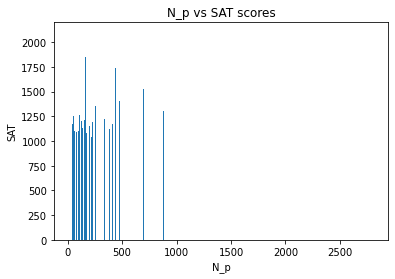

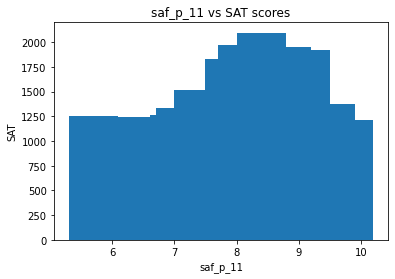

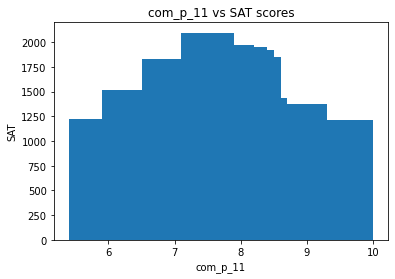

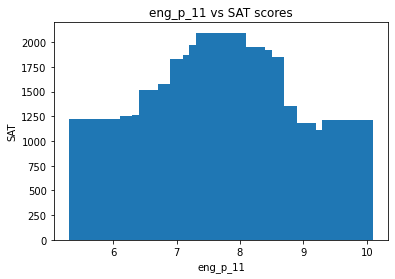

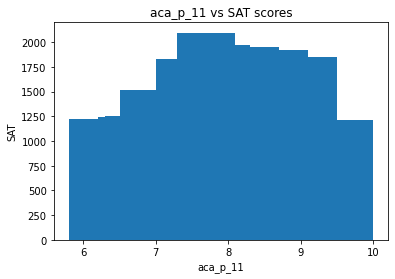

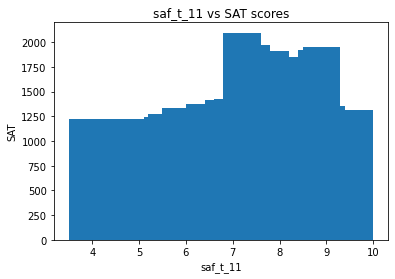

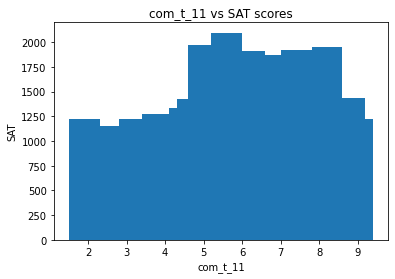

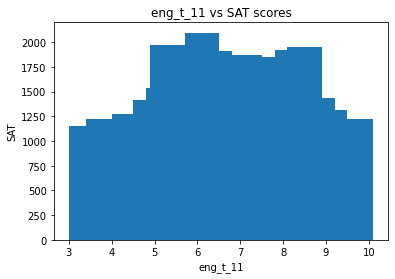

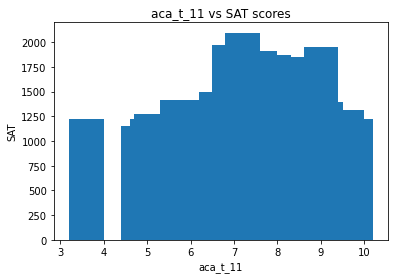

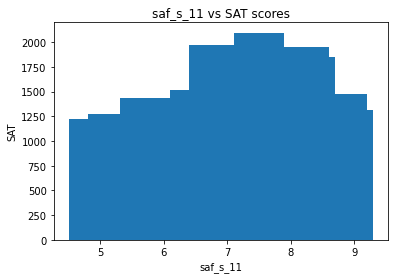

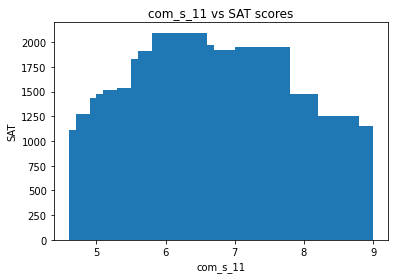

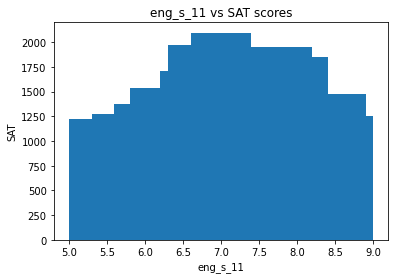

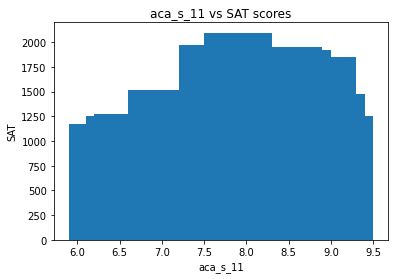

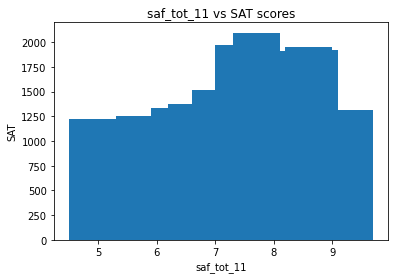

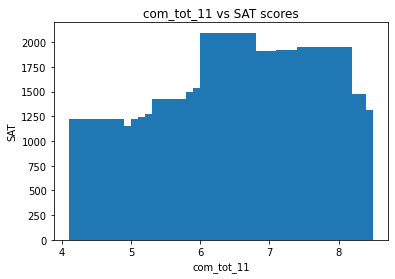

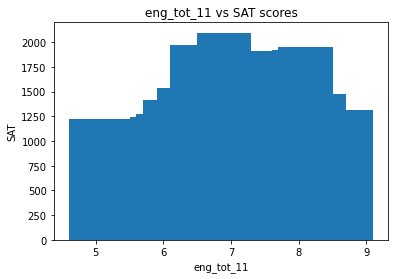

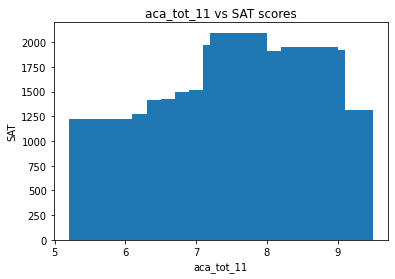

In [13]:
for f in survey_fields:
    plt.bar(combined.loc[:, f], combined['sat_score'])
    plt.title('{} vs SAT scores'.format(f))
    plt.xlabel(f)
    plt.ylabel('SAT')
    plt.show()

In [14]:
survey_corr = combined.loc[:, ['sat_score', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']]
correlations = survey_corr.corr()
print(correlations)

            sat_score  saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11
sat_score    1.000000    0.318753    0.077310    0.100102    0.190966
saf_tot_11   0.318753    1.000000    0.759778    0.798355    0.832943
com_tot_11   0.077310    0.759778    1.000000    0.936956    0.932689
eng_tot_11   0.100102    0.798355    0.936956    1.000000    0.939890
aca_tot_11   0.190966    0.832943    0.932689    0.939890    1.000000


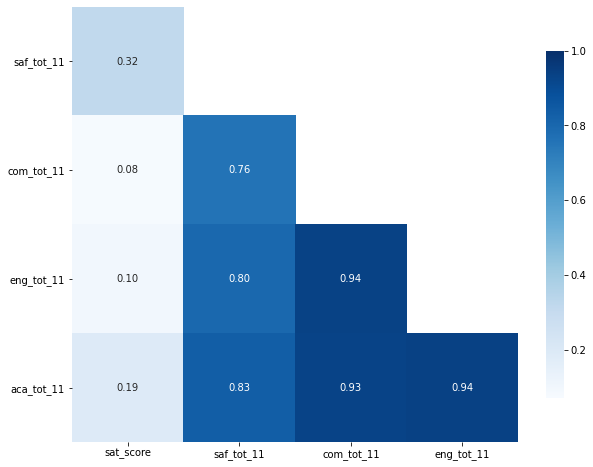

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()
# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=0.07, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

Among several factors that were evaluated in the survey among students, parents and teachers (safety, communication, engagement, academic expectations) no significant correlation was found with high SAT scores based on correlation matrix. The most important factor with Pearson's correlation coefficient = 0.32 is high level of safety and respect. Other factors show more strong covarience with each other (coefficients for emgagement and communication and academic expectations all are over 0.9).

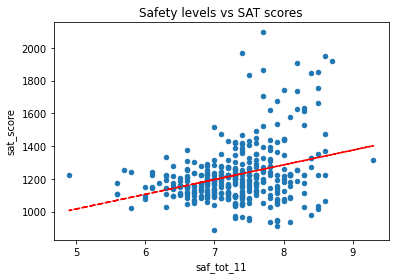

In [16]:
combined.plot('saf_tot_11', 'sat_score', kind='scatter', title='Safety levels vs SAT scores')

z = np.polyfit(combined['saf_tot_11'], combined['sat_score'], 1)
p = np.poly1d(z)
plt.plot(combined['saf_tot_11'],p(combined['saf_tot_11']),"r--")


In [17]:
group_boro = combined.groupby(["boro"]).mean()
print(group_boro['sat_score'].sort_values(ascending=True))
print('Will mean safety levels have the same distribution?')
print(group_boro['saf_tot_11'].sort_values(ascending=True))

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64
Will mean safety levels have the same distribution?
boro
Brooklyn         7.129245
Staten Island    7.200000
Bronx            7.322581
Queens           7.387500
Manhattan        7.473333
Name: saf_tot_11, dtype: float64


On the one hand schools from Bronx and Brooklyn with the lowest mean SAT scores also are evaluated with lower safety levels, while Queens and Manhattan got higher safety ratings also having higher SAT scores. Interesting exception from that trend is a borough of Staten Island which was evaluated with a low safety level while having top SAT scores. 


<AxesSubplot:title={'center':'Safety levels vs SAT scores at Staten Island'}, xlabel='saf_tot_11', ylabel='sat_score'>

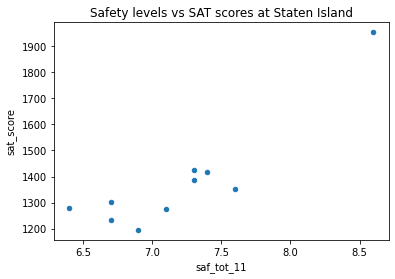

In [18]:
st_island = combined[combined['boro'] == 'Staten Island']
st_island.plot('saf_tot_11', 'sat_score', kind='scatter', title='Safety levels vs SAT scores at Staten Island')

In [19]:
print(st_island[st_island['sat_score'] > 1600][['DBN', 'SchoolName', 'sat_score', 'saf_tot_11']])

        DBN                  SchoolName  sat_score  saf_tot_11
356  31R605  STATEN ISLAND TECHNICAL HS     1953.0         8.6


The only borough that doesn't follow the trend, Staten Island has few schools - 10 (at least in that dataset), with one clear outlier with the high levels of SAT scores and high level of safety.
Next step is to visualize how average SAT scores vary across the area of New York. To create more fine-grained distibution I decided to make a choropleth map based on zip codes of the schools. Foor that I downloaded the shapefile with zip borders from [here](https://maps.princeton.edu/catalog/nyu-2451-34509).

In [20]:
# read shapefile and create gdf
shapefile = 'schools/ny-zip/nyu_2451_34509.shp'
zip_map = gpd.read_file(shapefile)
zip_map.head()

,zcta,bcode,note,geometry
0,10001,36061,None,"POLYGON ((-74.00368 40.74835, -74.00653 40.749..."
1,10002,36061,None,"POLYGON ((-73.99695 40.71207, -73.99712 40.712..."
2,10003,36061,None,"POLYGON ((-73.99206 40.72564, -73.99179 40.726..."
3,10007,36061,None,"POLYGON ((-74.01046 40.71153, -74.01015 40.712..."
4,10009,36061,None,"POLYGON ((-73.97521 40.71924, -73.97512 40.719..."


In [21]:
# convert zip codes to integers
zip_map['zcta'] = zip_map['zcta'].astype('int64')

<AxesSubplot:>

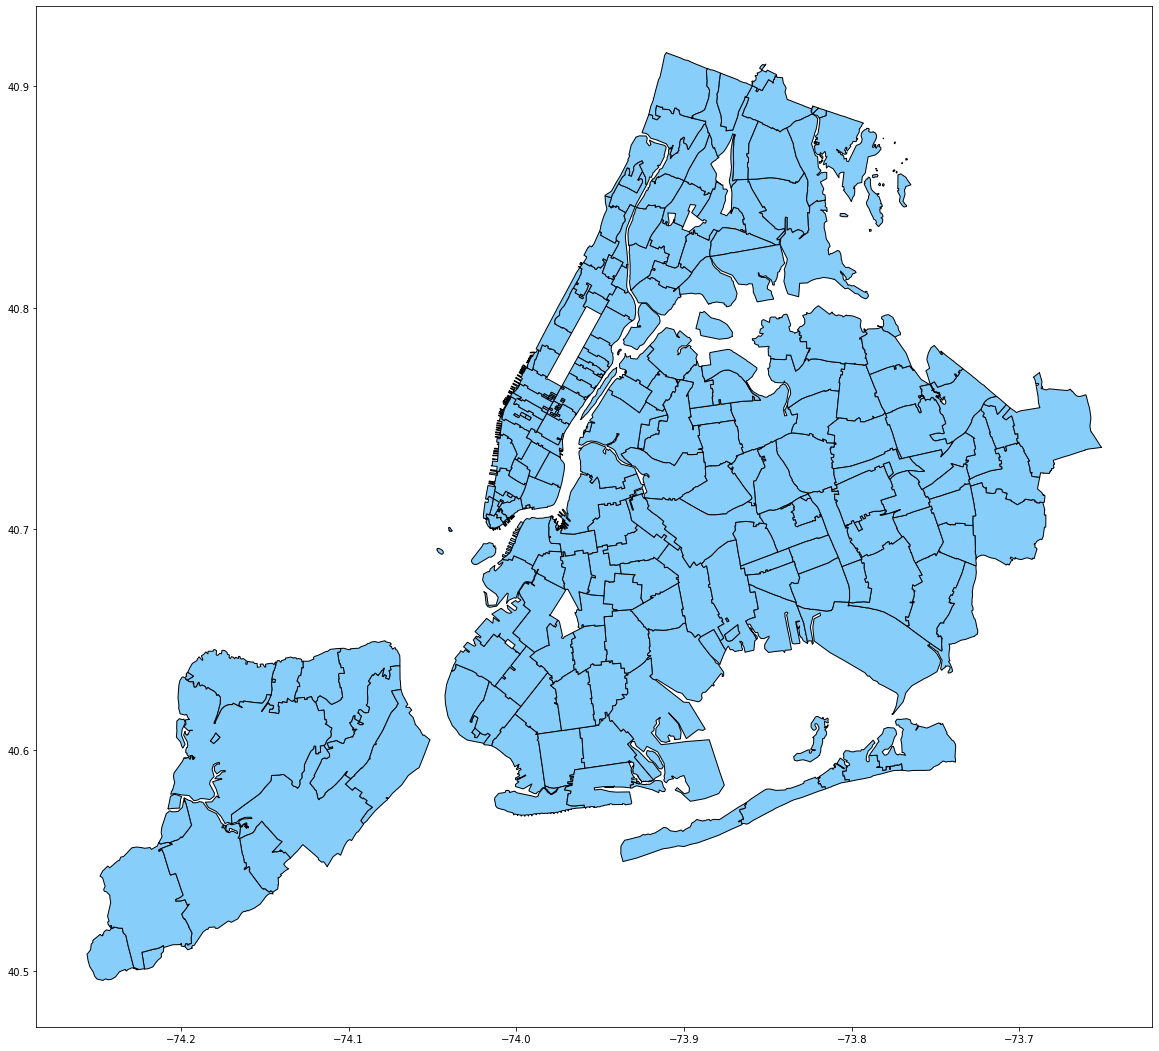

In [22]:
fig,ax = plt.subplots(figsize=(20, 20))
zip_map.plot(ax=ax, color='lightskyblue', edgecolor='black')

In [23]:
avg_sat = pd.pivot_table(combined, values='sat_score', index=['zip'], aggfunc=np.mean)
avg_sat.reset_index(inplace=True)
avg_sat['sat_score'].describe()

count     116.000000
mean     1253.039597
std       156.921921
min       951.000000
25%      1145.914552
50%      1223.438806
75%      1317.898028
max      2096.000000
Name: sat_score, dtype: float64

In [31]:
merged = zip_map.set_index('zcta').join(avg_sat.set_index('zip'))
merged.dropna(subset=['sat_score'], inplace=True)
merged.drop(columns='note', inplace=True)
merged.reset_index(inplace=True)
merged.head()

,zcta,bcode,geometry,sat_score
0,10002,36061,"POLYGON ((-73.99695 40.71207, -73.99712 40.712...",1306.090909
1,10003,36061,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",1232.219403
2,10009,36061,"POLYGON ((-73.97521 40.71924, -73.97512 40.719...",1149.000000
3,10036,36061,"POLYGON ((-73.99819 40.76492, -73.99774 40.765...",1338.000000
4,10004,36061,"MULTIPOLYGON (((-74.02666 40.68571, -74.02661 ...",1287.000000


Text(0.5, 1.0, 'Preventable death rate in London')

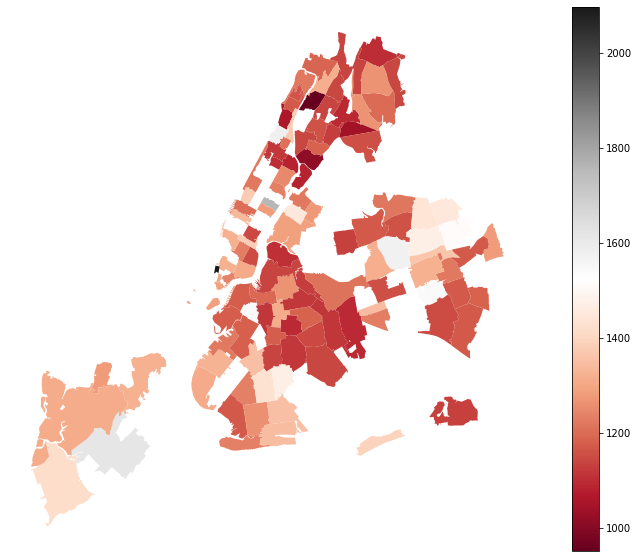

In [57]:
# create map
merged.plot(column='sat_score', cmap='RdGy', figsize=(16,10), legend=True).axis('off')

(-74.23829869999997, -73.68533529999998, 40.48984404999982, 40.92792894999983)

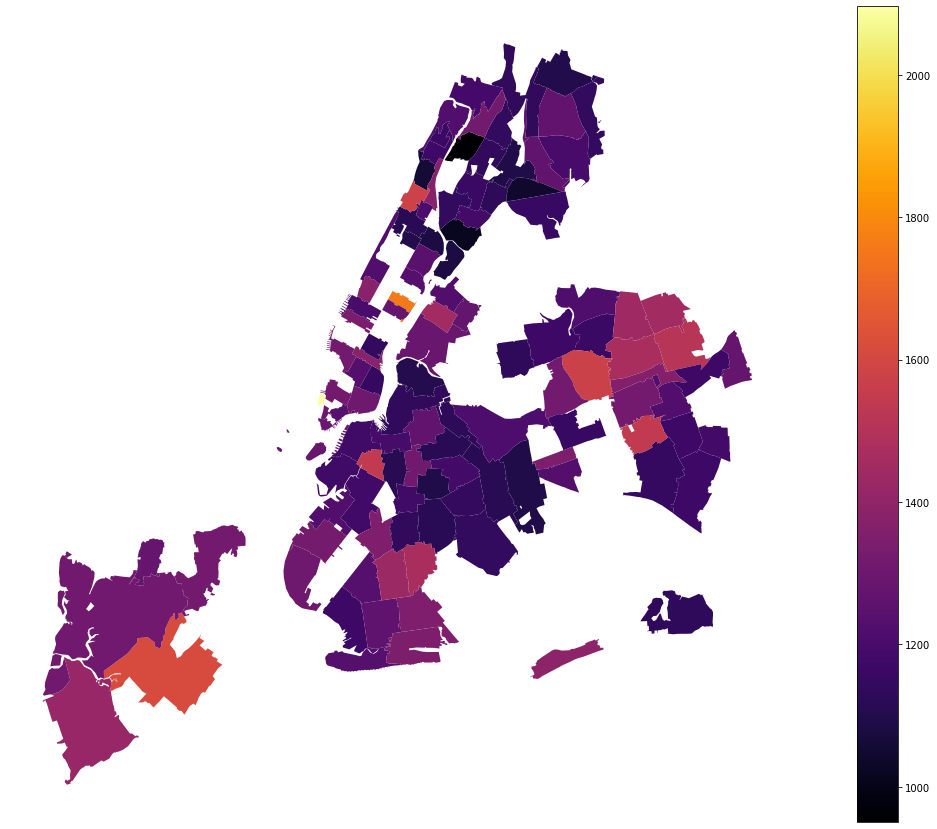

In [61]:
fig,ax = plt.subplots(1, figsize=(25, 15))
merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])
merged.plot(column='sat_score', ax=ax, cmap='inferno', figsize=(16,10), legend=True)
ax.axis('off')